## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [145]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [146]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [147]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [148]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [149]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [150]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [151]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [152]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [153]:
target = 'survived'

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
pclass      1309 non-null int64
survived    1309 non-null int64
sex         1309 non-null object
age         1046 non-null float64
sibsp       1309 non-null int64
parch       1309 non-null int64
fare        1308 non-null float64
cabin       295 non-null object
embarked    1307 non-null object
title       1309 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB


In [155]:
vars_num = [var for var in data.columns if data[var].dtype in ('float','int') and var != 'survived']

vars_cat = [var for var in data.columns if var not in vars_num and var != 'survived']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [156]:
# first in numerical variables
num_with_na = [var for var in data[vars_num] if data[var].isnull().sum() > 0]
data[num_with_na].isnull().mean().sort_values(ascending=False)

age     0.200917
fare    0.000764
dtype: float64

In [157]:
# now in categorical variables
cat_with_na = [var for var in data[vars_cat] if data[var].isnull().sum() > 0]
data[cat_with_na].isnull().mean().sort_values(ascending=False)

cabin       0.774637
embarked    0.001528
dtype: float64

### Determine cardinality of categorical variables

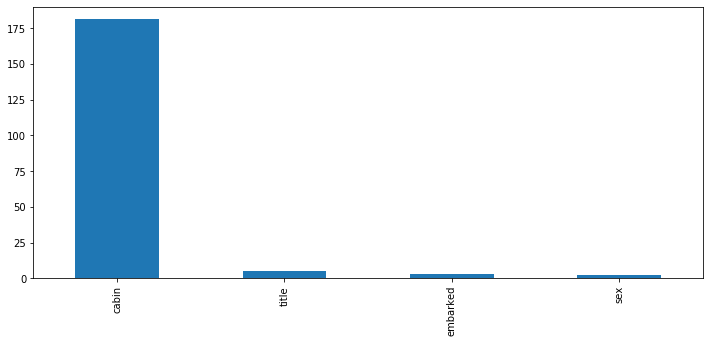

In [158]:
# Count unique categories with panda unique() and plot them in descending order

data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Determine the distribution of numerical variables

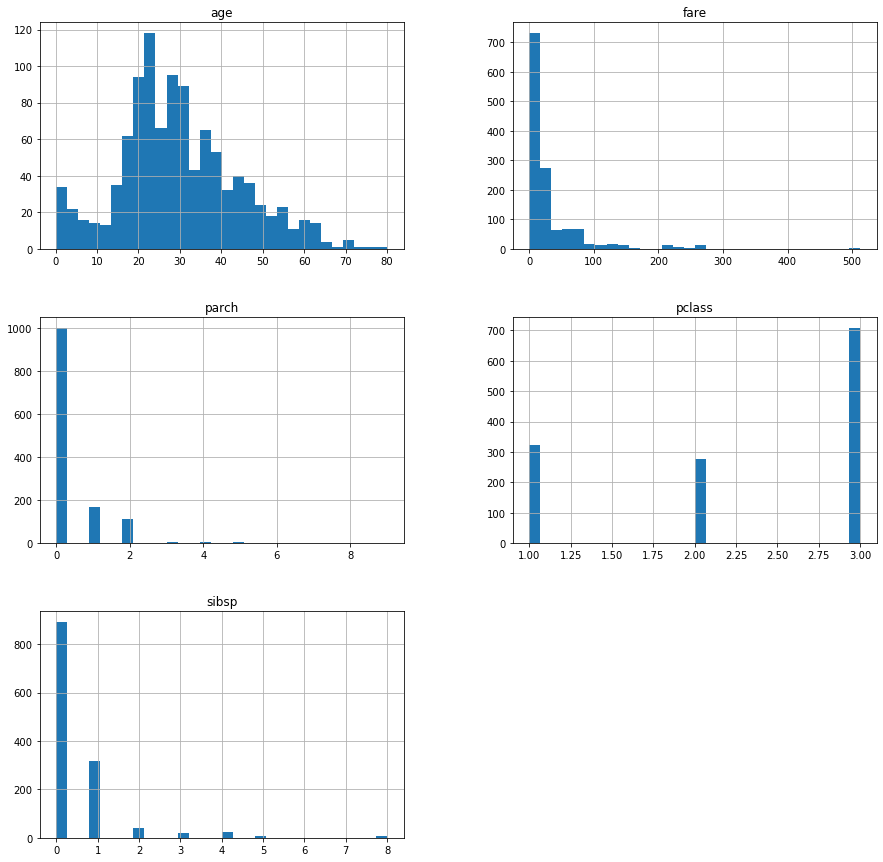

In [159]:
data[vars_num].hist(bins=30, figsize=(15, 15))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [160]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [161]:
# Need to skip the nan, otherwise there will be errors
data['cabin'] = data['cabin'].apply(lambda x: x[0] if(np.all(pd.notnull(x))) else x)

In [162]:
data['cabin']

0         B
1         C
2         C
3         C
4         C
       ... 
1304    NaN
1305    NaN
1306    NaN
1307    NaN
1308    NaN
Name: cabin, Length: 1309, dtype: object

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [163]:
for var in num_with_na:
    
    # calculate the mean using the train set
    median_val = X_train[var].median()
    print(var, median_val)
    
    # add binary indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
    
    # replace missing values with median in train and test set
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)
    
# Make sure we don't have missing values
X_train[num_with_na].isnull().sum()

age 28.0
fare 14.4542


age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [164]:
X_train[cat_with_na] = X_train[cat_with_na].fillna('Missing')
X_test[cat_with_na] = X_test[cat_with_na].fillna('Missing')

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [165]:
tmp = X_train.groupby('cabin')['cabin'].count() / len(X_train)
frequent_ls = list(tmp[tmp < 0.05].index)
frequent_ls

['A10',
 'A11',
 'A14',
 'A16',
 'A18',
 'A19',
 'A20',
 'A21',
 'A24',
 'A26',
 'A29',
 'A34',
 'A36',
 'A5',
 'A6',
 'A7',
 'A9',
 'B101',
 'B102',
 'B18',
 'B19',
 'B20',
 'B22',
 'B24',
 'B26',
 'B28',
 'B3',
 'B30',
 'B35',
 'B36',
 'B37',
 'B39',
 'B4',
 'B41',
 'B42',
 'B45',
 'B49',
 'B5',
 'B50',
 'B51',
 'B52',
 'B57',
 'B58',
 'B61',
 'B69',
 'B71',
 'B73',
 'B77',
 'B78',
 'B79',
 'B86',
 'B94',
 'B96',
 'C101',
 'C103',
 'C105',
 'C110',
 'C111',
 'C116',
 'C118',
 'C123',
 'C124',
 'C125',
 'C126',
 'C128',
 'C130',
 'C132',
 'C148',
 'C2',
 'C22',
 'C23',
 'C28',
 'C30',
 'C32',
 'C39',
 'C45',
 'C46',
 'C47',
 'C49',
 'C51',
 'C52',
 'C54',
 'C55',
 'C6',
 'C62',
 'C65',
 'C68',
 'C7',
 'C78',
 'C80',
 'C82',
 'C83',
 'C85',
 'C86',
 'C87',
 'C89',
 'C90',
 'C91',
 'C92',
 'C93',
 'C95',
 'C97',
 'C99',
 'D',
 'D15',
 'D17',
 'D19',
 'D20',
 'D21',
 'D26',
 'D28',
 'D30',
 'D33',
 'D34',
 'D35',
 'D36',
 'D37',
 'D38',
 'D40',
 'D43',
 'D46',
 'D47',
 'D49',
 'D50',
 'D

In [168]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are less than a certain %
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp < rare_perc]

for var in vars_cat:
    
    #find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')
                                        
X_train.shape, X_test.shape

sex Series([], Name: sex, dtype: float64)

cabin cabin
A10    0.000955
A11    0.000955
A14    0.000955
A16    0.000955
A18    0.000955
         ...   
F33    0.002865
F38    0.000955
F4     0.002865
G6     0.003820
T      0.000955
Name: cabin, Length: 159, dtype: float64

embarked embarked
Missing    0.00191
Name: embarked, dtype: float64

title title
Master    0.044890
Other     0.025788
Name: title, dtype: float64



((1047, 11), (262, 11))

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [169]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

In [170]:
def one_hot_encoding(df, var_list):
    for var in var_list:
        # drop first will create k-1 variables
        ohe_df = pd.get_dummies(df[var],drop_first=True)
        df = pd.concat([df , ohe_df], axis = 1)
        df.drop(var, axis=1, inplace=True)
        
    return df

In [171]:
X_train = one_hot_encoding(X_train, vars_cat)
X_test = one_hot_encoding(X_test, vars_cat)

In [172]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na
1118,3,25.0,0,0,7.9250,0,0
44,1,41.0,0,0,134.5000,0,0
1072,3,28.0,0,0,7.7333,1,0
1130,3,18.0,0,0,7.7750,0,0
574,2,29.0,1,0,21.0000,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [173]:
# Create scaler
scaler = StandardScaler()

# Fit the scaler to the train set
scaler.fit(X_train)

# sklearn returns numpy arrays, so we wrap it to dataframe
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

In [174]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na
0,0.835808,-0.370162,-0.478911,-0.455423,-0.504782,-0.494921,-0.03092
1,-1.542157,0.904029,-0.478911,-0.455423,1.971555,-0.494921,-0.03092
2,0.835808,-0.131251,-0.478911,-0.455423,-0.508533,2.020526,-0.03092
3,0.835808,-0.927621,-0.478911,-0.455423,-0.507717,-0.494921,-0.03092
4,-0.353174,-0.051614,0.434422,-0.455423,-0.248980,-0.494921,-0.03092


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [175]:
from sklearn.linear_model import Lasso

In [176]:
lin_model = Lasso(alpha=0.0005, random_state=0)
lin_model.fit(X_train, y_train)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [178]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [181]:
# make predictions for train set
pred = lin_model.predict(X_train)

# determine roc-auc, prediction is probability so we don't need to transform to binary
print('train accurroc_auc_score: {}'.format(roc_auc_score(y_train, pred)))

train accurroc_auc_score: 0.715517774343122


In [184]:
# transform probability to binary
pred = np.where(pred >= 0.5, 1, 0)
pred

array([0, 1, 0, ..., 0, 1, 0])

In [185]:
print('train accuracy: {}'.format(accuracy_score(y_train, pred)))

train accuracy: 0.6886341929321872


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**